In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from pathlib import Path
from tensorflow import keras

#Tools for balancing data
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

#Tools for building neural networks
from keras.models import Sequential
from keras.layers import Conv2D

#Tools for processing the images
from skimage import color
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold

#Tools for preparing train, test, and validation sets
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from collections import Counter

#Seperate file containing custom functions
from my_functions import * 

# Preprocessing the data

In this step, we will preprocess the data so as to make it usable for our models. Firstly we will import the data using the original csv that we created in the Data Loading and Visualisation notebook.

In [85]:
#Import the data
my_data = pd.read_csv('kuzushiji_raw.csv')
print(my_data.shape)
my_data.head()

(1086326, 5)


,Book ID,Unicode,Character,File,Count
0,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
1,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
2,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
3,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
4,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1


We can see that the dataframe consists of 5 columns and 1,086,326 rows. However we know from the Data Loading and Visualisation notebook that a large number of the characters in this dataset consist of only a single observation.

This is going to be an issue for our models. The reason is that for these characters it will be impossible to have these characters represented in both the training and test datasets. This means that if a character is only represented in the training set, we will be unable to see how the model performs with classifying it. Likewise, if the character is only represented in the test set, then the model is left with trying to classify a character that it has never seen before.

There are a few approaches that we could take to address this. On the one hand we could try generating synthetic data from the observations we have through methods such as image augmentation, train the classifier on the augmented data and use the original image to test it. However this method could result in overfitting and compromise the value of our model as we would be testing it with data that it has technically been trained on already.

Another approach could be to assume that each character with a single observation comes from a normal distribution and we could assume that the observation that we do have represents the distribution's mean. We could then use this to generate synthetic data and follow a similar method as described above. However this approach would also require making a lot of assumptions about the data and compromising on the value of our model. There would be no way for example to know if a synthetic sample generated from just a single observation would resemble anything close to what an actual character in a classical text would look like.

For these reasons, we will remove characters from the dataset that only have a single observation, and make a new dataframe which only includes characters which have two or more observations. 

In [40]:
#Isolating characters with only a single observation

#Get an array with the Unicodes
characters = np.array(my_data['Unicode']) 

#Group all characters by their Unicode this returns two numpy arrays representing the characters 
#and the count of each character in the dataframe

unique_char, counts = np.unique(characters, return_counts=True)

#Merge the two arrays into a dictionary
counted = dict(zip(unique_char, counts))

len(counted)

4328

In [94]:
#Remove all characters with only a single observation
no_single_characters = {char:count for char, count in counted.items() if count != 1}
no_single_characters = list(no_single_characters.keys())

print("Number of unique characters with 2 or more observations: "+str(len(no_single_characters)))


Number of unique characters with 2 or more observations: 3538


In [76]:
#Create a new dataframe only consisting of characters with 2 or more observations
new_data = my_data[my_data.Unicode.isin(no_single_characters)]

In [84]:
print(new_data.shape)
new_data.head()

(1085536, 5)


,Book ID,Unicode,Character,File,Count
0,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
1,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
2,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
3,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
4,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1


We can now see from the shape that this new dataframe has less rows than the original one. If we calculate the difference between the two we can see that it is 790 (as the new dataframe is not including any characters with only a single obervation).

In [86]:
print("The difference in rows is: "+str(my_data.shape[0]-new_data.shape[0]))

The difference in rows is: 790


# Splitting the data into training and test groups

Now that we have removed characters with only a single observation, we can split our data into training as test groups. However as we are working with 3538 unique classes, there is a chance that if we simply sample randomly, we could end up with a train and test set with two very different distributions in terms of class representation. We will therefore use stratified sampling to preserve the distribution of each class.

In [92]:
#Convert the unicode labels to integers so we can use them with our classifier
labels = new_data['Unicode']
labels = labels.values.tolist()
label_encoder = LabelEncoder()
Y = np.array(label_encoder.fit_transform(labels))
Y = np.array(labels)
Y


#Create a training and testing set
x_train, x_test, y_train, y_test = train_test_split(new_data['File'], Y,random_state=42,train_size=0.01,stratify=Y)


#Convert the pandas series to lists
x_train = x_train.tolist()
y_train = y_train.tolist()

#Examine the size of each set
print("The training set has "+ str(len(x_train))+" observations")
print("The test set has "+ str(len(x_test))+" observations")



The training set has 10855 observations
The test set has 1074681 observations


At the moment, the training and testsets only contain lists of file names rather than the images themselves

In [96]:
print(x_train[3])
print(x_test[333])

./all/200008316/characters/U+507D/U+507D_200008316_00016_1_X1050_Y1703.jpg
./all/200019865/characters/U+30CF/U+30CF_200019865_00077_2_X0838_Y2054.jpg


In the next step we will start working with the images themselves.

# Examining and processing the Images

The Kuzushiji data set consists of both full pages from the books, as well as images of the individual characters on each page. Here is a sample image of a full page.

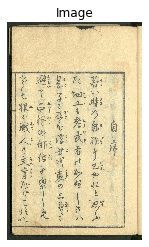

In [103]:
#Load a sample page image
file = Path("all/100241706/images/100241706_00004_2.jpg")
stem = file.stem

sample_page = plt.imread(file)
show_image(sample_page)

However, we will be using the images of the individual characters for our classifier. Here is a sample image:



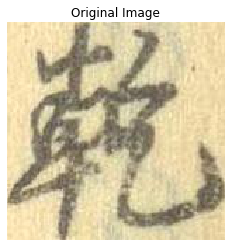

In [123]:
sample_char = plt.imread("all/100241706/characters/U+4E7E/U+4E7E_100241706_00029_1_X1774_Y1384.jpg")
show_image(sample_char,"Original Image")


In the next step, we will load all of the images using the file names we have stored and apply several transformations to them in order to use the images with our models. 

Specifically these transformations will involve three steps:

1. We will convert them from RGB into grayscale. A standared RGB image represented by three arrays of nxn elements. Where each array represents a colour (red, blue, and green), each element corresponds to a pixel, and the element's value represents the pixel intensity of the colour in the image. By converting to grayscale we are reducing this to just one colour channel/one array.


2. We will then apply thresholding to make the images completely black and white. This works by setting a critical value, and assigning any pixel greater than this value to white, and any pixel less than it to black. This essentially creates a single array consisting of binary values and will make it easier for our models to process. It will also help address issues such as ink from characters on the opposite side of the page interfering with the model's calculations.


3. Finally we will resize each image so they are all the same size. The reason for this is because for image classifiers, each pixel represents an independent variable. Our models will require values for all of the variables to properly work. In this case we will set the images to be 224 by 224 pixels.

Below is an example of each of the transformations with a sample image.


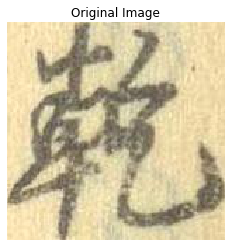

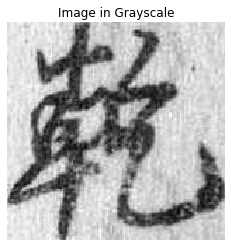

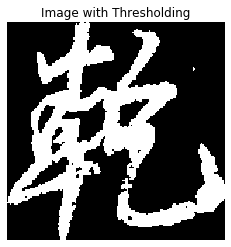

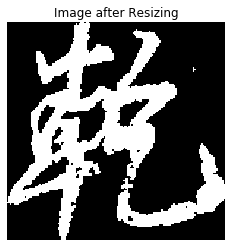

In [124]:
#Original image
show_image(sample_char,"Original Image")

#Convert image to grayscale
sample_char = color.rgb2gray(sample_char)
show_image(sample_char,'Image in Grayscale')

#Apply thresholding to the image to make it Black and White
#Find the critical value
thresh_otsu = threshold_otsu(sample_char)
#Apply thresholding
sample_char = sample_char <= thresh_otsu 
show_image(sample_char, "Image with Thresholding")

#Resize the image to make it 224 by 224 pixels
img_size = 224
sample_char = resize(sample_char,(img_size,img_size))

show_image(sample_char,"Image after Resizing")




In [131]:
#Load all of the images, convert them to grayscale, apply thresholding and resize them all to 224 by 224.
x_train = process_images(x_train,img_size)


KeyboardInterrupt: 

Here is a sample image from the training set after it has been processed

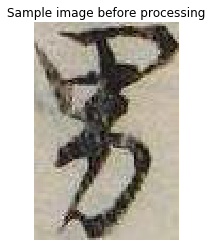

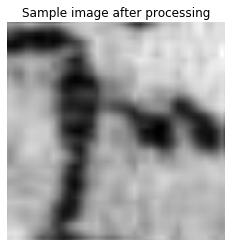

In [180]:
show_image(x_train[100],'Sample image after processing')



array([[['./all/200003803/characters/U+3068/U+3068_200003803_00012_2_X1537_Y1139.jpg']],

       [['./all/200015843/characters/U+3064/U+3064_200015843_00040_1_X1461_Y1134.jpg']],

       [['./all/200021086/characters/U+65E5/U+65E5_200021086_00015_2_X0720_Y2796.jpg']],

       ...,

       [['./all/200014740/characters/U+3053/U+3053_200014740_00081_1_X0287_Y1283.jpg']],

       [['./all/200017458/characters/U+307C/U+307C_200017458_00024_1_X1186_Y0643.jpg']],

       [['./all/200015779/characters/U+306F/U+306F_200015779_00124_1_X1778_Y0546.jpg']]],
      dtype='<U75')

In [126]:
y_train = np.array(y_train)

In [128]:
unique, counts = np.unique(y_train, return_counts=True)
count = dict(zip(unique, counts))
count

{'U+25B2': 2,
 'U+25B3': 1,
 'U+25CB': 13,
 'U+25CF': 1,
 'U+3005': 7,
 'U+3007': 1,
 'U+300C': 11,
 'U+3031': 37,
 'U+3032': 3,
 'U+303B': 4,
 'U+3042': 110,
 'U+3044': 184,
 'U+3046': 123,
 'U+3048': 14,
 'U+304A': 94,
 'U+304B': 269,
 'U+304C': 93,
 'U+304D': 146,
 'U+304E': 13,
 'U+304F': 163,
 'U+3050': 10,
 'U+3051': 104,
 'U+3052': 15,
 'U+3053': 102,
 'U+3054': 18,
 'U+3055': 122,
 'U+3056': 21,
 'U+3057': 378,
 'U+3058': 30,
 'U+3059': 107,
 'U+305A': 34,
 'U+305B': 68,
 'U+305C': 6,
 'U+305D': 68,
 'U+305E': 16,
 'U+305F': 182,
 'U+3060': 41,
 'U+3061': 48,
 'U+3062': 7,
 'U+3063': 1,
 'U+3064': 123,
 'U+3065': 20,
 'U+3066': 322,
 'U+3067': 39,
 'U+3068': 289,
 'U+3069': 43,
 'U+306A': 242,
 'U+306B': 402,
 'U+306C': 35,
 'U+306D': 38,
 'U+306E': 413,
 'U+306F': 261,
 'U+3070': 64,
 'U+3071': 1,
 'U+3072': 97,
 'U+3073': 19,
 'U+3075': 109,
 'U+3076': 14,
 'U+3078': 128,
 'U+3079': 29,
 'U+307B': 37,
 'U+307C': 11,
 'U+307D': 1,
 'U+307E': 136,
 'U+307F': 53,
 'U+3080': 31,


In [133]:
x_train = np.expand_dims(x_train, -1)

oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(x_train, y_train)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [187]:
unique, counts = np.unique(y_over, return_counts=True)
counted = dict(zip(unique, counts))
counted

{0: 49,
 28: 49,
 45: 49,
 51: 49,
 52: 49,
 53: 49,
 54: 49,
 55: 49,
 56: 49,
 57: 49,
 58: 49,
 59: 49,
 60: 49,
 61: 49,
 62: 49,
 63: 49,
 64: 49,
 66: 49,
 67: 49,
 68: 49,
 69: 49,
 70: 49,
 71: 49,
 72: 49,
 74: 49,
 75: 49,
 76: 49,
 77: 49,
 78: 49,
 79: 49,
 81: 49,
 82: 49,
 83: 49,
 84: 49,
 85: 49,
 86: 49,
 87: 49,
 88: 49,
 89: 49,
 90: 49,
 91: 49,
 92: 49,
 93: 49,
 95: 49,
 98: 49,
 99: 49,
 101: 49,
 102: 49,
 104: 49,
 105: 49,
 107: 49,
 108: 49,
 109: 49,
 110: 49,
 111: 49,
 113: 49,
 115: 49,
 117: 49,
 118: 49,
 119: 49,
 120: 49,
 121: 49,
 122: 49,
 123: 49,
 124: 49,
 125: 49,
 126: 49,
 127: 49,
 128: 49,
 132: 49,
 134: 49,
 135: 49,
 146: 49,
 148: 49,
 173: 49,
 189: 49,
 192: 49,
 193: 49,
 202: 49,
 205: 49,
 219: 49,
 246: 49,
 248: 49,
 251: 49,
 252: 49,
 253: 49,
 258: 49,
 266: 49,
 269: 49,
 270: 49,
 284: 49,
 287: 49,
 289: 49,
 292: 49,
 293: 49,
 298: 49,
 308: 49,
 311: 49,
 316: 49,
 317: 49,
 321: 49,
 324: 49,
 341: 49,
 358: 49,
 368: 4

In [188]:
#Split the training set to create a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 


In [189]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[224,224]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(4328,activation="softmax"))


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [190]:
x_val, y_val = np.array(x_val), np.array(y_val)

In [ ]:
model.fit(x_over,y_over,epochs=30, validation_data=(x_val,y_val))

Epoch 1/30
501/501 [==============================] - 70s 139ms/step - loss: 4.1932 - accuracy: 0.2561 - val_loss: 3.5164 - val_accuracy: 0.3051
Epoch 2/30
501/501 [==============================] - 69s 137ms/step - loss: 1.0052 - accuracy: 0.7847 - val_loss: 2.2798 - val_accuracy: 0.5294
Epoch 3/30
501/501 [==============================] - 66s 132ms/step - loss: 0.5426 - accuracy: 0.8769 - val_loss: 1.8312 - val_accuracy: 0.6176
Epoch 4/30
501/501 [==============================] - 59s 117ms/step - loss: 0.3869 - accuracy: 0.9071 - val_loss: 1.6678 - val_accuracy: 0.6213
Epoch 5/30
501/501 [==============================] - 51s 102ms/step - loss: 0.3359 - accuracy: 0.9171 - val_loss: 1.3629 - val_accuracy: 0.6949
Epoch 6/30
501/501 [==============================] - 48s 97ms/step - loss: 0.3036 - accuracy: 0.9254 - val_loss: 0.9175 - val_accuracy: 0.7500
Epoch 7/30
501/501 [==============================] - 48s 96ms/step - loss: 0.2432 - accuracy: 0.9380 - val_loss: 1.6640 - val_accu

In [167]:
unique, counts = np.unique(y_val, return_counts=True)


In [168]:
counts

array([ 1,  4,  3,  3,  2,  5,  3,  5,  1,  2,  4,  2,  2,  9,  1,  2,  1,
        1,  5,  2,  6,  3,  2, 11,  9,  7, 10,  1, 10, 11,  4,  1,  3,  2,
        2,  5,  1,  3,  6,  8,  8,  3,  1,  1,  5,  5,  2,  1,  1,  1,  2,
        1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [169]:
count = dict(zip(unique, counts))

In [173]:
x = 0
for key in count:
    if count[key] ==1:
        x +=1
        print(x)
        
len(y_val)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


272

In [174]:
80/272

0.29411764705882354